<a href="https://colab.research.google.com/github/khanabdulmajid/tensorflow_deep_learning/blob/main/07_Project_1_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1. Food Vision

In [1]:
!nvidia-smi -L

# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

GPU 0: Tesla T4 (UUID: GPU-e4454e5e-f73f-d7ef-a952-d66f430fce61)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.4/493.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.3 MB/s eta 0:00:00
TensorFlow version: 2.15.0-dev20230913
Notebook last run (end-to-end): 2023-09-14 07:26:50.653426


In [2]:
#getting helper functions
!wget https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py

--2023-09-14 07:26:50--  https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-14 07:26:50 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, plot_loss_curves

In [4]:
# download some data from tensorflow dataset

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(tf.__version__)
datasets_list=tfds.list_builders()
print("food101" in datasets_list)

2.15.0-dev20230913
True


In [6]:
(train_data,test_data), ds_info=tfds.load("food101",
                                          split=["train","validation"],
                                          shuffle_files=True,
                                          as_supervised=True, #data is returned in tuple format (data,label)
                                          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ1K4ZQ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ1K4ZQ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


#Exploring data form tfds

In [7]:
 ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
#get class names
class_names=ds_info.features["label"].names
class_names

## exporing food101 dataset from tf
need to find
* classnames
* shape of our inputdata (image tensors)
* their data type
* what their labels look like (one-hot encode or lale encoded)
* do the labels match up with the class names

In [25]:
#take one sample of train data
train_one_sample=train_data.take(1)

In [26]:
for image, label in train_one_sample:
  print(f"""
  image_shape: {image.shape}
  image_datatype:{image.dtype}
  taget_class:{label},
  class_name:{class_names[label]}
        """

  )

TypeError: ignored

list

conclusion
* labels are not one-hot encoded


In [10]:
#min and max values in the image
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

TypeError: ignored

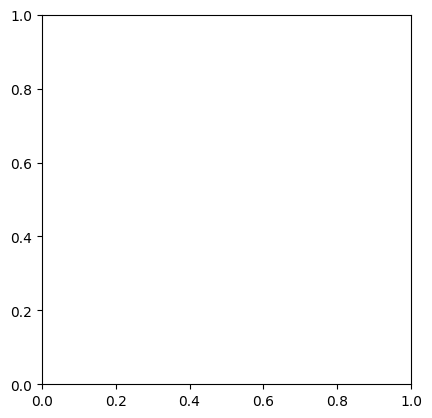

In [30]:
# plot the image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [31]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [32]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[[115.35204   116.35204   118.35204  ]
   [109.188774  110.188774  112.188774 ]
   [ 96.65306    97.65306    99.65306  ]
   ...
   [116.627556   73.19897    92.41326  ]
   [117.954094   72.954094   92.954094 ]
   [117.11735    73.11735    90.11735  ]]

  [[ 94.102036   95.102036   97.102036 ]
   [104.30612   105.30612   107.30612  ]
   [121.10714   122.10714   124.10714  ]
   ...
   [111.500015   68.500015   87.07143  ]
   [113.13776    70.13776    87.13776  ]
   [107.52553    64.52553    81.52553  ]]

  [[113.44388   114.44388   116.44388  ]
   [118.82653   119.82653   121.82653  ]
   [119.668365  120.668365  122.668365 ]
   ...
   [110.07138    69.71424    85.499954 ]
   [104.08669    63.729553   79.51527  ]
   [104.21938    63.86224    79.64796  ]]

  ...

  [[ 40.571342   36.142815   23.714285 ]
   [ 45.071342   40.499958   28.086733 ]
   [ 48.81112    41.147865   28.316236 ]
   ...
   [108.4285    112.4285    115.4285   ]
   [106.91316   110.91316   

# Batch and prepare datasets
fetch the data from tfds through a pipeline

In [14]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [33]:
# creating a callback
model_checkpoint_dir="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_dir,
                                                    monitor="val_acc",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0
                                                    )

In [17]:
#mixed precisiontraiing

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data plolicy to mixed precision


Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the TensorFlow mixed precision guide (I'd highly recommend at least checking out the summary).

Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.

    🔑 Note: If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: "Supported Hardware" in the mixed precision guide for more).

    📖 Resource: If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the Wikipedia page (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the tensorflow.keras.mixed_precision API has made it very easy for us to get started.

First, we'll import the API and then use the set_global_policy() method to set the dtype policy to "mixed_float16".


In [34]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [35]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False



In [ ]:
for layer in base_model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

In [37]:
input_shape=(224,224,3)
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="GAP2d")(x)
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation(activation="softmax",dtype=tf.float32,name="softmaxfloat_32")(x)
# make sure our outputs are in dtype float32

model_1=tf.keras.Model(inputs,outputs)
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_101=model_1.fit(train_data,
                        epochs=8,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*(len(test_data))),
                        callbacks=[create_tensorboard_callback("training_logs","efficientnetb0"),
                                   model_checkpoint]
                        )

Saving TensorBoard log files to: training_logs/efficientnetb0/20230914-074548
Epoch 1/8
2368/2368 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.5821

2368/2368 [==============================] - 225s 87ms/step - loss: 1.7203 - accuracy: 0.5821 - val_loss: 1.1275 - val_accuracy: 0.6928
Epoch 2/8
 363/2368 [===>..........................] - ETA: 2:31 - loss: 1.2474 - accuracy: 0.6804

In [22]:
plot_loss_curves(history_101)

NameError: ignored

#Fine Tuning

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False